In [80]:
!ls
!mkdir models

README.md               model_epoch1            t10k-labels-idx1-ubyte
fashion-mnist_test.csv  model_epoch2            train-images-idx3-ubyte
fashion-mnist_train.csv model_epoch3            train-labels-idx1-ubyte
fashion.ipynb           model_epoch4
model_epoch0            t10k-images-idx3-ubyte


In [78]:
#IMPORTS
import pandas as pd
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [47]:
#LOAD CSV DATA
#tr_filename = 'fashion-mnist_train.csv'
#tr = pd.read_csv(tr_filename)

In [48]:
#LOAD IMAGE DATA
f = 'train-images-idx3-ubyte'
l = 'train-labels-idx1-ubyte'
imagearray = idx2numpy.convert_from_file(f)
labels = idx2numpy.convert_from_file(l)

tf = 't10k-images-idx3-ubyte'
tl = 't10k-labels-idx1-ubyte'
test_imagearray = idx2numpy.convert_from_file(tf)
test_labels = idx2numpy.convert_from_file(tl)

(60000, 28, 28)


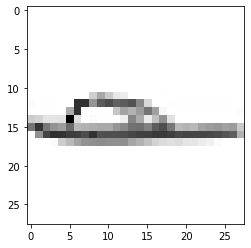

In [49]:
plt.imshow(imagearray[30], cmap=plt.cm.binary)
print(imagearray.shape)
#print(label_map[labels[30]])
#print(imagearray[30])

In [50]:
#Preprocessing, normalize data
class Normalize:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = np.mean(X)
        self.std = np.std(X)
        
    def normalize(self, X):
        X -= self.mean
        X /= self.std
        return X

In [51]:
imgs = imagearray.copy()
lbls = labels.copy()
test_imgs = test_imagearray.copy()
test_lbls = test_labels.copy()

imgs.flags.writeable = True
imgs = imgs.astype(np.float64)
test_imgs.flags.writeable = True
test_imgs = test_imgs.astype(np.float64)

scale = Normalize()
scale.fit(imgs)

imgs = scale.normalize(imgs)
test_imgs = scale.normalize(test_imgs)
#imgs.dtype=np.float32
#test_imgs.dtype = np.float32

In [52]:
print(test_imgs.dtype)

float64


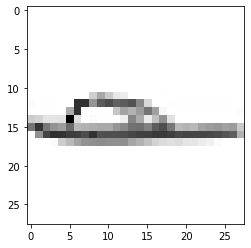

In [53]:
plt.imshow(imgs[30], cmap=plt.cm.binary)

In [37]:
#Split training data into training and validation sets
def train_val_split(X, y, percent=85):
    percent = float(percent)
    if(percent > 1): 
        percent = percent/100
    assert X.shape[0] == y.shape[0]
    idxs = np.random.permutation(y.shape[0])
    i = int(percent*y.shape[0])
    train_X, train_y = X[0: i], y[0: i]
    val_X, val_y = X[i:], y[i:]
    return train_X, train_y, val_X, val_y

In [10]:
train_X, train_y, val_X, val_y = train_val_split(imgs, lbls)

In [11]:
#Store all hyperparameters here
hyperparams = {
    'batch_size': 50,
    'learning_rate': 1e-4,
    'num_epochs': 50,
}

In [95]:
#Define data loaders to cooperate with torch training loop
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(val_X), torch.from_numpy(val_y))
tr_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)

#Do we need to define a Dataset & DataLoader for the test dataset?
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_imgs), torch.from_numpy(test_lbls))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hyperparams['batch_size'], shuffle=False)

In [65]:
#Define CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 5, 5, 2)
        self.conv2 = nn.Conv2d(5, 50, 5, 2)
        
        self.fc1 = nn.Linear(800, 100)
        self.fc2 = nn.Linear(100, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        
        x = x.view(50, 1, 28, 28)
        b, c, h, w = x.shape
        #print(x.shape)
        #Conv layer 1
        x = F.relu(self.conv1(x))
        #print(x.shape)
        #Conv layer 2
        x = F.relu(self.conv2(x))
        #print(x.shape)
        #Flatten
        x = x.view(b, 800)
        #print(x.shape)
        #Fully connected 1
        #z = self.fc1(x)
        #print(f'after fc1 shape {z.shape}')
        x = F.relu(self.fc1(x))
        #print(x.shape)
        #Fully connected 2
        x = F.relu(self.fc2(x))
        #print(x.shape)
        #Fully connected 3, (does not apply softmax... yet)
        x = self.fc3(x)
        
        return x

#Apply softmax to get predicted label
def predict(network_output):
    
    assert network_output.shape[1] == 10
    
    pred = F.softmax(network_output, 1)
    
    return torch.argmax(pred, dim=1)

#Load and save model funcs from state_dict
def save(model, path):
    torch.save(model.state_dict(), path)
    
def load(path, eval_mode = False):
    model = CNN()
    model.load_state_dict(torch.load(path))
    if eval_mode:
        model.eval()   
    return model
    

In [82]:
#training loop
model = CNN()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])

train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(hyperparams['num_epochs']):
    
    #Evaluate training batch
    for i, (X, y) in enumerate(tr_loader):
        X = X.float()
        y = y.long()
        #Zero out gradients
        optim.zero_grad()
        
        
        #Forward pass of training batch
        output = model(X)
        
        #Compute loss of batch
        loss = criterion(output, y)
        
        #Calculate gradients (backprop)
        loss.backward()
        
        #Update parameters (ADAM)
        optim.step()
    
   
    
    
    #Evaluate training AND validation accuracy && loss
    y_true, y_pred = [], []
    correct, total = 0.0, 0.0
    running_loss = []
    
    for (X, y) in tr_loader:
        X = X.float()
        y = y.long()
        with torch.no_grad():
            output = model(X.float())
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (preds == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    train_loss.append(np.mean(running_loss))
    train_acc.append(correct/total)
    
    y_true, y_pred = [], []
    correct, total = 0.0, 0.0
    running_loss = []
    for X, y in val_loader:
        X = X.float()
        y = y.long()
        with torch.no_grad():
            output = model(X)
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (preds == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    val_loss.append(np.mean(running_loss))
    val_acc.append(correct/total)
    
    if epoch % 2 == 0:
        print(f'Train loss: {train_loss[-1]}')
        print(f'Train acc: {train_acc[-1]}')
        print(f'Val loss: {val_loss[-1]}')
        print(f'Val acc: {val_acc[-1]}')
    
    
    #Save model
    save(model, os.path.join('models', f'model_epoch{epoch}'))

Train loss: 0.6979983013926768
Train acc: 0.7398823529411764
Val loss: 0.6947623312473297
Val acc: 0.7427777777777778
Train loss: 0.5394862996596916
Train acc: 0.7910196078431373
Val loss: 0.5433356086413066
Val acc: 0.7897777777777778
Train loss: 0.48358774771000823
Train acc: 0.8191960784313725
Val loss: 0.4957339011960559
Val acc: 0.8138888888888889
Train loss: 0.4356116902740563
Train acc: 0.8432745098039216
Val loss: 0.44937517046928405
Val acc: 0.8362222222222222
Train loss: 0.41135081621799985
Train acc: 0.852
Val loss: 0.4349177458220058
Val acc: 0.8436666666666667
Train loss: 0.38451390316819445
Train acc: 0.8616666666666667
Val loss: 0.4101291788121065
Val acc: 0.8513333333333334
Train loss: 0.37212417765575295
Train acc: 0.8643725490196078
Val loss: 0.3957323363257779
Val acc: 0.8532222222222222
Train loss: 0.36158372683121875
Train acc: 0.8667450980392157
Val loss: 0.39271933800644343
Val acc: 0.8588888888888889
Train loss: 0.34249129616746715
Train acc: 0.8743529411764706


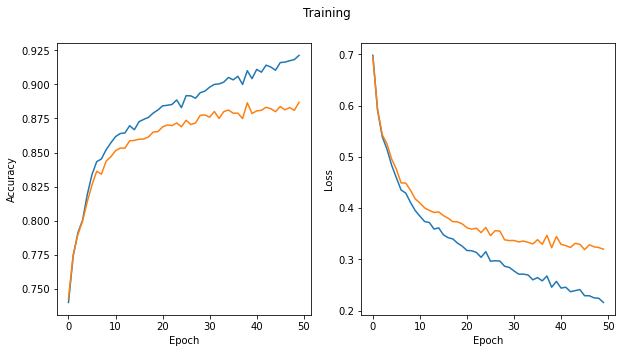

In [85]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 
plt.suptitle('Training') 
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy') 
axes[1].set_xlabel('Epoch') 
axes[1].set_ylabel('Loss')
x = np.arange(len(train_loss))
axes[0].plot(x, train_acc)
axes[1].plot(x, train_loss)
axes[0].plot(x, val_acc)
axes[1].plot(x, val_loss)
plt.show()

In [88]:
#TEST FULL TRAIN FOR 65 EPOCHS
final_model = CNN()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(final_model.parameters(), lr=hyperparams['learning_rate'])


for epoch in range(65):
    
    #Evaluate training batch
    for i, (X, y) in enumerate(tr_loader):
        X = X.float()
        y = y.long()
        #Zero out gradients
        optim.zero_grad()
        
        
        #Forward pass of training batch
        output = final_model(X)
        
        #Compute loss of batch
        loss = criterion(output, y)
        
        #Calculate gradients (backprop)
        loss.backward()
        
        #Update parameters (ADAM)
        optim.step()
        
    for i, (X, y) in enumerate(val_loader):
        X = X.float()
        y = y.long()
        #Zero out gradients
        optim.zero_grad()
        
        
        #Forward pass of training batch
        output = final_model(X)
        
        #Compute loss of batch
        loss = criterion(output, y)
        
        #Calculate gradients (backprop)
        loss.backward()
        
        #Update parameters (ADAM)
        optim.step()
    
   
    
    
    #Evaluate training AND validation accuracy && loss
    y_true, y_pred = [], []
    correct, total = 0.0, 0.0
    
    
    for (X, y) in tr_loader:
        X = X.float()
        y = y.long()
        with torch.no_grad():
            output = final_model(X.float())
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (preds == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    
    
    y_true, y_pred = [], []
    
    running_loss = []
    for X, y in val_loader:
        X = X.float()
        y = y.long()
        with torch.no_grad():
            output = final_model(X)
            preds = predict(output)
            
            y_true.append(y)
            y_pred.append(preds)
            
            total += y.size(0)
            correct += (preds == y).sum().item()
            
            running_loss.append(criterion(output, y).item())
    
    tl = np.mean(running_loss)
    ta = correct/total
    
    if epoch % 20 == 0:
        print(f'Train loss: {tl}')
        print(f'Train acc: {ta}')
        
    
    
    #Save model
save(final_model, os.path.join('models', f'final_model_65'))

Train loss: 0.6301723816328578
Train acc: 0.7533
Train loss: 0.3170169335686498
Train acc: 0.88155
Train loss: 0.2513565404133664
Train acc: 0.9047166666666666
Train loss: 0.20598342294494312
Train acc: 0.9209833333333334


In [91]:
print(test_lbls)

[9 2 1 ... 8 1 5]


In [102]:
y_true = []
y_pred = []

for (X,y) in test_loader:
    X = X.float()
    y = y.long()
    
    with torch.no_grad():
        output = final_model(X)
        preds = predict(output)

        y_true += y.tolist()
        y_pred += preds.tolist()

total = len(y)
correct = (preds == y).sum().item()

print(f'Accuracy {correct/total}')

Accuracy 0.84


In [113]:
df = pd.DataFrame(data={'Id':np.arange(1,1+len(y_pred)), 'Label':y_pred})

In [114]:
df.head()

,Id,Label
0,1,9
1,2,2
2,3,1
3,4,1
4,5,6


In [115]:
df.tail()

,Id,Label
9995,9996,9
9996,9997,1
9997,9998,8
9998,9999,1
9999,10000,5


In [116]:
df.to_csv('submission.csv', index=False)